In [1]:
from tqdm.auto import tqdm

### Train the Tokenizer

In [2]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()

In [3]:
from pathlib import Path
paths = [str(x) for x in Path('./data/text/oscar_uk').glob('**/*.txt')]

In [4]:
tokenizer.train(files=paths[:10], vocab_size=30_522, min_frequency=2,
                special_tokens=['<s>', '<pad>', '</s>', '<unk>', '<mask>'])

In [5]:
import os

os.mkdir('panas1')
tokenizer.save_model('panas1')

['panas1\\vocab.json', 'panas1\\merges.txt']

In [6]:
from transformers import RobertaTokenizer

# initialize the tokenizer using the tokenizer we initialized and saved to file
tokenizer = RobertaTokenizer.from_pretrained('panas1', max_len=512)

file panas1\config.json not found


In [7]:
txt = (
    "На території Собору Святої Софії Київської у неділю, 22 серпня відбулася божественна літургія, яку "
    "очолили Вселенський патріарх Варфоломій та митрополит Київський і всієї України Епіфаній."
    "У соборній літургії взяли участь майже 15 тисяч священиків та вірян."
)
tokenizer(txt, max_length=512, padding='max_length', truncation=True)

{'input_ids': [0, 902, 1885, 7463, 653, 27778, 19877, 5365, 331, 9141, 16, 2506, 3519, 5651, 15246, 9890, 327, 17484, 9404, 16, 2112, 11192, 348, 23554, 684, 18814, 5216, 342, 5797, 385, 345, 26741, 14294, 320, 8025, 543, 1242, 1144, 342, 15211, 18, 545, 15498, 611, 17484, 8459, 4577, 1552, 2466, 1336, 2652, 23293, 345, 997, 14620, 18, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Input Pipeline

In [8]:
with open('./data/text/oscar_uk/text_0.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
len(batch)

2

In [9]:
import torch

labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])

# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()

# create random array of floats with equal dims to input_ids
rand = torch.rand(input_ids.shape)

# mask random 15% where token is not 0 [PAD], 1 [CLS], or 2 [SEP]
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)

# loop through each row in input_ids tensor (cannot do in parallel)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3
input_ids.shape

torch.Size([5000, 512])

In [11]:
print(len(lines), len(labels))

5000 5000


In [12]:
lines[10]

'Суд позбавив А. і Волкова офіцерських звань і вийшов з представленням до ПВР СРСР про позбавлення їх державних нагород, також постановив знищити рукописи А. і Волкова «как предметы, не представляющие никакой ценности».22.12.1982 р. А. етапом вивезений у Мордовію. У табір ЖХ-385/3-4, що в сел. Барашево Теньгушовського р-ну, прибув 30.12. Тут були політв`язні В. СТРІЛЬЦІВ, Ю. БАДЗЬО, Ю. МЕЛЬНИК, Д. МАЗУР, пізніше Володимир Делидівка, Г. КУЦЕНКО, Євген Анцупов, Г. АЛТУНЯН.Оскільки вирок А. був надто інформативний (28 с.), його на руки не дали. Зона ж вимагала: «Покажи вирок». Тоді А. попросив спецчастину надати йому вирок для написання скарги. Його зачинили під замок, але він передав вирок через кватирку в зону. Його прочитали і повернули.Політв΄язні-«антирадянщики» (чоловік 30–40) становили кістяк табору. Вивчали юриспруденцію, писали скарги та заяви, відзначати голодівками День політв\x92язня – 30 жовтня та 10 грудня – День прав людини, сиділи в карцерах. По неділях влаштовували своєрі

### Build the DataLoader

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

In [13]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True) # CUDA out of memory if batch_size=16

In [14]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=30_522,  # we align this to the tokenizer vocab_size
    max_position_embeddings=514,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)

In [15]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [16]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

In [17]:
epochs = 1
loss_hist = []
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/625 [00:00<?, ?it/s]

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

tensor(0.2020, device='cuda:0', grad_fn=<NllLossBackward>)


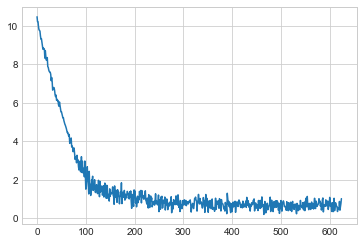

In [19]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

In [20]:
with open('./data/text/oscar_uk/text_1.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3

In [21]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/625 [00:00<?, ?it/s]

tensor(0.2020, device='cuda:0', grad_fn=<NllLossBackward>)


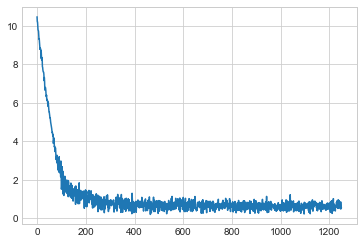

In [22]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

In [23]:
with open('./data/text/oscar_uk/text_2.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3

In [24]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

loss_hist = []
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/625 [00:00<?, ?it/s]

tensor(0.1400, device='cuda:0', grad_fn=<NllLossBackward>)


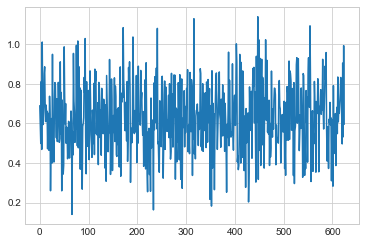

In [25]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

### Try to fill the masked text

In [26]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model=model.to('cpu'), tokenizer=tokenizer)

C:\Users\Asus\anaconda3\envs\torch\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [27]:
# could you plpease tell me where is...?
unmasker(f'Скажіть, будь ласка, де  {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скажіть, будь ласка, де?',
  'score': 0.4063747823238373,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скажіть, будь ласка, де ваги?',
  'score': 0.0003808412002399564,
  'token': 11841,
  'token_str': ' ваги'},
 {'sequence': 'Скажіть, будь ласка, де нормативної?',
  'score': 0.00022684186114929616,
  'token': 28182,
  'token_str': ' нормативної'},
 {'sequence': 'Скажіть, будь ласка, де Всього?',
  'score': 0.00020784768275916576,
  'token': 13600,
  'token_str': ' Всього'},
 {'sequence': 'Скажіть, будь ласка, де визначаються?',
  'score': 0.00020170923380646855,
  'token': 12263,
  'token_str': ' визначаються'}]

In [28]:
# How old are you?
# Скільки тобі років?
unmasker(f'Скільки тобі {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скільки тобі?',
  'score': 0.3244904577732086,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки тобі спортсмен?',
  'score': 0.00040761532727628946,
  'token': 8042,
  'token_str': ' спортсмен'},
 {'sequence': 'Скільки тобі визначаються?',
  'score': 0.000352613307768479,
  'token': 12263,
  'token_str': ' визначаються'},
 {'sequence': 'Скільки тобі табл?',
  'score': 0.00033263597288168967,
  'token': 30499,
  'token_str': ' табл'},
 {'sequence': 'Скільки тобі оборот?',
  'score': 0.00023346382658928633,
  'token': 19393,
  'token_str': ' оборот'}]

In [29]:
# I am thirsty
# Я хочу пити
unmasker(f'Я хочу {unmasker.tokenizer.mask_token}.')

[{'sequence': 'Я хочу.',
  'score': 0.37248122692108154,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Я хочуасти.',
  'score': 0.00022000244644004852,
  'token': 27558,
  'token_str': 'асти'},
 {'sequence': 'Я хочугун.',
  'score': 0.00021459683193825185,
  'token': 20113,
  'token_str': 'гун'},
 {'sequence': 'Я хочуліку.',
  'score': 0.00020222057355567813,
  'token': 15667,
  'token_str': 'ліку'},
 {'sequence': 'Я хочу 800.',
  'score': 0.00019505257660057396,
  'token': 11375,
  'token_str': ' 800'}]

In [30]:
unmasker(f'{unmasker.tokenizer.mask_token} хочу пити.')

[{'sequence': ' хочу пити.',
  'score': 0.21628455817699432,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'тивно хочу пити.',
  'score': 0.0003017832350451499,
  'token': 18275,
  'token_str': 'тивно'},
 {'sequence': ' хронічного хочу пити.',
  'score': 0.00028776892577297986,
  'token': 28200,
  'token_str': ' хронічного'},
 {'sequence': 'сист хочу пити.',
  'score': 0.0002845696290023625,
  'token': 8423,
  'token_str': 'сист'},
 {'sequence': 'Дон хочу пити.',
  'score': 0.0002736362221185118,
  'token': 20268,
  'token_str': 'Дон'}]

In [31]:
# Speak slower please
# Говоріть повільніше, будь ласка
unmasker(f'{unmasker.tokenizer.mask_token} повільніше, будь ласка.')

[{'sequence': ' повільніше, будь ласка.',
  'score': 0.26622310280799866,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' Кодексом повільніше, будь ласка.',
  'score': 0.0003346733283251524,
  'token': 15877,
  'token_str': ' Кодексом'},
 {'sequence': '2008 повільніше, будь ласка.',
  'score': 0.00033172054099850357,
  'token': 8542,
  'token_str': '2008'},
 {'sequence': 'сять повільніше, будь ласка.',
  'score': 0.0003246970009058714,
  'token': 5159,
  'token_str': 'сять'},
 {'sequence': 'Постій повільніше, будь ласка.',
  'score': 0.0003236877091694623,
  'token': 27581,
  'token_str': 'Постій'}]

In [32]:
# How much is this?
# Скільки це коштує?
unmasker(f'Скільки це {unmasker.tokenizer.mask_token} ?')

[{'sequence': 'Скільки це?',
  'score': 0.27030864357948303,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки цедитор?',
  'score': 0.0003184306260664016,
  'token': 26274,
  'token_str': 'дитор'},
 {'sequence': 'Скільки це злив?',
  'score': 0.00030043828883208334,
  'token': 28390,
  'token_str': ' злив'},
 {'sequence': 'Скільки це здійснюють?',
  'score': 0.00028263055719435215,
  'token': 7515,
  'token_str': ' здійснюють'},
 {'sequence': 'Скільки це розпов?',
  'score': 0.0002782805822789669,
  'token': 3498,
  'token_str': ' розпов'}]

In [33]:
# Bye!
# До побачення!
unmasker(f'{unmasker.tokenizer.mask_token} побачення!')

[{'sequence': ' побачення!',
  'score': 0.2751995921134949,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': '2008 побачення!',
  'score': 0.0005197090795263648,
  'token': 8542,
  'token_str': '2008'},
 {'sequence': ' Передба побачення!',
  'score': 0.0004222544375807047,
  'token': 26455,
  'token_str': ' Передба'},
 {'sequence': ' любитель побачення!',
  'score': 0.00032014455064199865,
  'token': 30503,
  'token_str': ' любитель'},
 {'sequence': 'даються побачення!',
  'score': 0.0003191670693922788,
  'token': 9737,
  'token_str': 'даються'}]

Not much sense...

In [34]:
# save the model
model.save_pretrained('./panas1')